In [1]:
INSTANCE_ID = 'A_06'

In [2]:
import os
import json
import math
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sko.GA import GA
from sko.tools import set_run_mode

# device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
# torch.cuda.empty_cache()

In [3]:
def read_json(filename: str):
    """Read a json file and return data as a dict object"""

    print('Reading json file ' + filename + '...')
    f = open(filename, 'r')
    Instance = json.load(f)
    f.close()
    print('Done')

    return Instance

In [4]:
GAP = 0.05
TIME_LIMIT = 900 # 15 mins

RESOURCES_STR = 'Resources'
SEASONS_STR = 'Seasons'
INTERVENTIONS_STR = 'Interventions'
EXCLUSIONS_STR = 'Exclusions'
T_STR = 'T'
SCENARIO_NUMBER = 'Scenarios_number'
RESOURCE_CHARGE_STR = 'workload'
TMAX_STR = 'tmax'
DELTA_STR = 'Delta'
MAX_STR = 'max'
MIN_STR = 'min'
RISK_STR = 'risk'
START_STR = 'start'
QUANTILE_STR = "Quantile"
ALPHA_STR = "Alpha"

# COST_P_SCHEDULE = 200000
# COST_P_RESOURCE = 5
# COST_P_EXCLUDE = 5

optimal_value = {
    "A_01": 1767.8156110,
    "A_02": 4671.3766110,
    "A_03": 848.1786111,
    "A_04": 2085.8760540,
    "A_05": 635.2217857,
    "A_06": 590.6235989,
    "A_07": 2272.7822740,
    "A_08": 744.2932352,
    "A_09": 1507.2847840,
    "A_10": 2994.8487350,
    "A_11": 495.2557702,
    "A_12": 789.6349276,
    "A_13": 1998.6621620,
    "A_14": 2264.1243210,
    "A_15": 2268.5691500
}

COST_P_SCHEDULE = optimal_value[INSTANCE_ID]
COST_P_RESOURCE = optimal_value[INSTANCE_ID] / 3
COST_P_EXCLUDE = optimal_value[INSTANCE_ID] / 3

In [5]:
def compute_resources(Instance: dict):
    """Compute effective workload (i.e. resources consumption values) for every resource and every time step"""

    # Retrieve usefull infos
    Interventions = Instance[INTERVENTIONS_STR]
    T_max = Instance[T_STR]
    Resources = Instance[RESOURCES_STR]
    # Init resource usage dictionnary for each resource and time
    resources_usage = {}
    for resource_name in Resources.keys():
        resources_usage[resource_name] = np.zeros(T_max)
    # Compute value for each resource and time step
    for intervention_name, intervention in Interventions.items():
        # start time should be defined (already checked in scheduled constraint checker)
        if not START_STR in intervention:
            continue
        start_time = intervention[START_STR]
        start_time_idx = start_time - 1 #index of list starts at 0
        intervention_worload = intervention[RESOURCE_CHARGE_STR]
        intervention_delta = int(intervention[DELTA_STR][start_time_idx])
        # compute effective worload
        for resource_name, intervention_resource_worload in intervention_worload.items():
            for time in range(start_time_idx, start_time_idx + intervention_delta):
                # null values are not available
                if str(time+1) in intervention_resource_worload and str(start_time) in intervention_resource_worload[str(time+1)]:
                    resources_usage[resource_name][time] += intervention_resource_worload[str(time+1)][str(start_time)]

    return resources_usage

def compute_risk_distribution(Interventions: dict, T_max: int, scenario_numbers):
    """Compute risk distributions for all time steps, given the interventions starting times"""

    # Init risk table
    risk = [scenario_numbers[t] * [0] for t in range(T_max)]
    # Compute for each intervention independently
    for intervention in Interventions.values():
        # Retrieve Intervention's usefull infos
        intervention_risk = intervention[RISK_STR]
        # start time should be defined (already checked in scheduled constraint checker)
        if not START_STR in intervention:
            continue
        start_time = intervention[START_STR]
        start_time_idx = int(start_time) - 1 # index for list getter
        delta = int(intervention[DELTA_STR][start_time_idx])
        for time in range(start_time_idx, start_time_idx + delta):
            for i, additional_risk in enumerate(intervention_risk[str(time + 1)][str(start_time)]):
                risk[time][i] += additional_risk

    return risk

## Compute mean for each period
def compute_mean_risk(risk, T_max: int, scenario_numbers):
    """Compute mean risk values over each time period"""

    # Init mean risk
    mean_risk = np.zeros(T_max)
    # compute mean
    for t in range(T_max):
        mean_risk[t] = sum(risk[t]) / scenario_numbers[t]

    return mean_risk

## Compute quantile for each period
def compute_quantile(risk, T_max: int, scenario_numbers, quantile):
    """Compute Quantile values over each time period"""

    # Init quantile
    q = np.zeros(T_max)
    for t in range(T_max):
        risk[t].sort()
        q[t] = risk[t][int(np.ceil(scenario_numbers[t] * quantile))-1]

    return q

## Compute total objective
def compute_objective(Instance: dict):
    """Compute total objectives (mean and expected excess)"""

    # Retrieve usefull infos
    T_max = Instance[T_STR]
    scenario_numbers = Instance[SCENARIO_NUMBER]
    Interventions = Instance[INTERVENTIONS_STR]
    quantile = Instance[QUANTILE_STR]
    # Retrieve risk final distribution
    risk = compute_risk_distribution(Interventions, T_max, scenario_numbers)
    # Compute mean risk
    mean_risk = compute_mean_risk(risk, T_max, scenario_numbers)
    # Compute quantile
    quantile = compute_quantile(risk, T_max, scenario_numbers, quantile)

    # Usefull infos
    alpha = Instance[ALPHA_STR]
    q = Instance[QUANTILE_STR]
    obj_1 = np.mean(mean_risk)
    tmp = np.zeros(len(quantile))
    obj_2 = np.mean(np.max(np.vstack((quantile - mean_risk, tmp)), axis=0))
    obj_tot = alpha * obj_1 + (1-alpha)*obj_2

    return obj_tot

In [6]:
## Launch each Constraint checks
def compute_penalty(Instance: dict):
    """Run all constraint checks"""

    total_penalty_cost = 0
    # Schedule constraints
    total_penalty_cost += COST_P_SCHEDULE * check_schedule(Instance)
    # Resources constraints
    total_penalty_cost += COST_P_RESOURCE * check_resources(Instance)
    # Exclusions constraints
    total_penalty_cost += COST_P_EXCLUDE * check_exclusions(Instance)

    return total_penalty_cost

## Schedule constraints: §4.1 in model description
def check_schedule(Instance: dict):
    """Check schedule constraints"""

    # Continuous interventions: §4.1.1
    #   This constraint is implicitly checked by the resource computation:
    #   computation is done under continuity hypothesis, and resource bounds will ensure the feasibility
    # Checks is done on each Intervention
    count = 0
    Interventions = Instance[INTERVENTIONS_STR]
    for intervention_name, intervention in Interventions.items():
        # Interventions are planned once: §4.1.2
        #   assert a starting time has been assigned to the intervention
        if not START_STR in intervention:
            print('ERROR: Schedule constraint 4.1.2: Intervention ' + intervention_name + ' has not been scheduled.')
            continue
        # Starting time validity: no explicit constraint
        start_time = intervention[START_STR]
        horizon_end = Instance[T_STR]
        if not (1 <= start_time <= horizon_end):
            count += 1
        # No work left: §4.1.3
        #   assert intervention is not ongoing after time limit or end of horizon
        time_limit = int(intervention[TMAX_STR])
        if time_limit < start_time:
            count += 1

    return count

## Resources constraints: §4.2 in model description
def check_resources(Instance: dict):
    """Check resources constraints"""

    count = 0
    T_max = Instance[T_STR]
    Resources = Instance[RESOURCES_STR]
    # Bounds are checked with a tolerance value
    tolerance = 1e-5
    # Compute resource usage
    resource_usage = compute_resources(Instance) # dict on resources and time
    # Compare bounds to usage
    for resource_name, resource in Resources.items():
        for time in range(T_max):
            # retrieve bounds values
            upper_bound = resource[MAX_STR][time]
            lower_bound = resource[MIN_STR][time]
            # Consumed value
            worload = resource_usage[resource_name][time]
            # Check max
            if worload > upper_bound + tolerance:
                count += 1
            # Check min
            if worload < lower_bound - tolerance:
                count += 1

    return count

## Exclusions constraints: §4.3 in model description
def check_exclusions(Instance: dict):
    """Check exclusions constraints"""

    count = 0
    # Retrieve Interventions and Exclusions
    Interventions = Instance[INTERVENTIONS_STR]
    Exclusions = Instance[EXCLUSIONS_STR]
    # Assert every exclusion holds
    for exclusion in Exclusions.values():
        # Retrieve exclusion infos
        [intervention_1_name, intervention_2_name, season] = exclusion
        # Retrieve concerned interventions...
        intervention_1 = Interventions[intervention_1_name]
        intervention_2 = Interventions[intervention_2_name]
        # start time should be defined (already checked in scheduled constraint checker)
        if (not START_STR in intervention_1) or (not START_STR in intervention_2):
            continue
        # ... their respective starting times...
        intervention_1_start_time = intervention_1[START_STR]
        intervention_2_start_time = intervention_2[START_STR]
        # ... and their respective deltas (duration)
        intervention_1_delta = int(intervention_1[DELTA_STR][intervention_1_start_time - 1]) # get index in list
        intervention_2_delta = int(intervention_2[DELTA_STR][intervention_2_start_time - 1]) # get index in list
        # Check overlaps for each time step of the season
        for time_str in Instance[SEASONS_STR][season]:
            time = int(time_str)
            if (intervention_1_start_time <= time < intervention_1_start_time + intervention_1_delta) and (intervention_2_start_time <= time < intervention_2_start_time + intervention_2_delta):
                count += 1

    return count

In [7]:
INSTANCE = read_json(os.path.join("./A_set", INSTANCE_ID + ".json"))

intervention_set = set(int(i.split('_')[1]) for i in list(INSTANCE['Interventions'].keys()))
n_dim = max(intervention_set) + 1
lb = [1 if i in intervention_set else 0 for i in range(n_dim)]
ub = [
    int(INSTANCE['Interventions']['Intervention_' + str(i)]['tmax']) if i in intervention_set 
        else 1
    for i in range(n_dim)
]

precision = [1] * n_dim

def checker(p):
    global n_dim, INSTANCE
    
    for i in intervention_set:
        INSTANCE[INTERVENTIONS_STR]['Intervention_' + str(i)][START_STR] = int(p[i])
        # instance[INTERVENTIONS_STR]['Intervention_' + str(i)][START_STR] = int(p[i])
    
    p_cost = compute_penalty(INSTANCE)
    obj_cost = compute_objective(INSTANCE)
    
    # p_cost = compute_penalty(solution)
    # obj_cost = compute_objective(solution)
    return obj_cost + p_cost

Reading json file ./A_set/A_05.json...
Done


In [8]:
set_run_mode(checker, 'multiprocessing')
ga = GA(
    func=checker, 
    n_dim=n_dim, 
    size_pop=200, 
    max_iter=800,
    # prob_mut=0.2,
    lb=lb, ub=ub, 
    precision=precision
)
ga.to(device=device)

10 Iterations: 4.16s, objective value 997.15 achieved with 2 violations
20 Iterations: 8.34s, objective value 913.17 achieved with 0 violations
30 Iterations: 12.43s, objective value 874.67 achieved with 0 violations
40 Iterations: 16.52s, objective value 836.79 achieved with 0 violations
50 Iterations: 20.35s, objective value 808.86 achieved with 0 violations
60 Iterations: 24.20s, objective value 786.04 achieved with 0 violations
70 Iterations: 27.77s, objective value 772.71 achieved with 0 violations
80 Iterations: 31.40s, objective value 762.98 achieved with 0 violations
90 Iterations: 35.07s, objective value 752.08 achieved with 0 violations
100 Iterations: 38.63s, objective value 742.13 achieved with 0 violations
110 Iterations: 42.19s, objective value 736.31 achieved with 0 violations
120 Iterations: 45.88s, objective value 729.61 achieved with 0 violations
130 Iterations: 49.36s, objective value 725.54 achieved with 0 violations
140 Iterations: 52.85s, objective value 719.07 ac

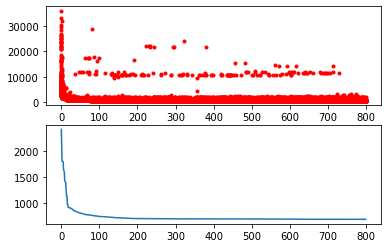

In [9]:
start_time = time.time()
for iter in range(80):
    best_x, best_y = ga.run(10)
    
    end_time = time.time() - start_time
    for i in intervention_set:
        INSTANCE[INTERVENTIONS_STR]['Intervention_' + str(i)][START_STR] = int(best_x[i])
        
    violation = check_schedule(INSTANCE) + check_resources(INSTANCE) + check_exclusions(INSTANCE)
    obj_cost = compute_objective(INSTANCE)
    print("{0} Iterations: {1:.2f}s, objective value {2:.2f} achieved with {3} violations".format(
        10*(iter+1), 
        end_time,
        obj_cost,
        violation
    ))

    if (end_time > TIME_LIMIT): 
        print("Time Limit Exceeded!")
        break
    if (obj_cost <= (1 + GAP)* optimal_value[INSTANCE_ID]):
        print("Optimal Value Achieved!")
        break

# print( 'best_x:', best_x, '\n', 'best_y:', best_y)

Y_history = pd.DataFrame(ga.all_history_Y)
fig, ax = plt.subplots(2, 1)
ax[0].plot(Y_history.index, Y_history.values, '.', color='red')
Y_history.min(axis=1).cummin().plot(kind='line')
plt.show()

In [10]:
for i in intervention_set:
    print('Intervention_' + str(i), int(best_x[i]))

Intervention_514 24
Intervention_515 84
Intervention_517 115
Intervention_518 21
Intervention_10 174
Intervention_11 56
Intervention_528 133
Intervention_17 158
Intervention_529 123
Intervention_19 171
Intervention_16 7
Intervention_536 116
Intervention_25 91
Intervention_26 135
Intervention_27 3
Intervention_541 176
Intervention_34 140
Intervention_40 142
Intervention_41 77
Intervention_43 173
Intervention_44 35
Intervention_48 172
Intervention_566 99
Intervention_569 156
Intervention_62 56
Intervention_67 137
Intervention_580 176
Intervention_581 136
Intervention_584 108
Intervention_585 175
Intervention_74 178
Intervention_73 133
Intervention_76 154
Intervention_75 171
Intervention_592 117
Intervention_83 71
Intervention_84 133
Intervention_597 74
Intervention_90 60
Intervention_602 135
Intervention_92 171
Intervention_605 133
Intervention_94 129
Intervention_609 168
Intervention_610 137
Intervention_615 168
Intervention_616 9
Intervention_619 123
Intervention_620 98
Intervention_62